In [1]:
import logging
import sys

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [2]:
import sys

import matplotlib.pyplot as plt

sys.path.append('../scripts')
sys.path.append('../')

from heapq import heappop, heappush
from itertools import count

import time
from multiprocessing import Pool
from time import sleep

import numpy as np
from tqdm.notebook import trange, tqdm
from scripts import centroids_graph_builder, graph_osm_loader, utils, clustering

import networkx as nx


In [3]:
def dijkstra_pfa_min_dst(graph: nx.Graph,
                 start: set[int],
                 ) -> \
        tuple[float, list[int]]:
    adjacency = graph._adj
    c = count()
    push = heappush
    pop = heappop
    dist = {}
    fringe = []
    for s in start:
        dist[s] = 0.0
        push(fringe, (0.0, next(c), s))
    while fringe:
        (d, _, v) = pop(fringe)
        for u, e in adjacency[v].items():
            vu_dist = d + e['length']
            if u not in dist or dist[u] > vu_dist:
                dist[u] = vu_dist
                push(fringe, (vu_dist, next(c), u))
    return dist


In [4]:
def get_rand_graph(N, p):
    G = nx.fast_gnp_random_graph(N, p, directed=False)
    if not nx.is_connected(G):
        tmp = []
        for n in nx.connected_components(G):
            for q in n:
                tmp.append(q)
                break
        for i in range(len(tmp) - 1):
            G.add_edge(tmp[i], tmp[i + 1])
    for e in G.edges:
        G.add_edge(e[0], e[1], length=np.random.random_sample() + 0.001)
    for u in G.nodes:
        if u in G[u]:
            G.remove_edge(u, u)
    return G

In [5]:
GRAPH_ID = 'R2555133'  # 'R13470549' 'R2555133' 'R3766483'
# примеры id есть в graph_osm_loader.py
# g = get_rand_graph(1000, 0.1)  # загрузка графа
N = 100000
p = 3/N
# g = get_rand_grAaph(N,p)
# g = get_graph()
g= graph_osm_loader.get_graph(GRAPH_ID)
print(len(g.nodes), len(g.edges))

17931 27047


In [6]:
g.remove_edges_from(nx.selfloop_edges(g))

In [52]:
cms = clustering.resolve_k_means_communities(g, resolution=500, max_iteration=100, print_log=True)

2024-12-09 17:21:36,872 - root - INFO - communities: 3409


100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


### community

In [7]:
import networkx as nx
import community  # python-louvain
import folium
import random
from collections import defaultdict

# # Применяем алгоритм Лувена для поиска сообществ
# partition = community.best_partition(g, weight='length')

# # Группируем id по значению
# grouped = defaultdict(set)
# for id, value in partition.items():
#     grouped[value].add(id)

# # Преобразуем в список множеств
# # cms = list(grouped.values())


def create_map(cms, g):
# Генерация случайных цветов для сообществ
    def generate_colors(n):
        return [f"#{random.randint(0, 0xFFFFFF):06x}" for _ in range(n)]

    unique_communities = set(range(len(cms)))
    colors = generate_colors(len(unique_communities))

    # Создаем отображение цвета для каждого сообщества
    community_colors = {community_id: color for community_id, color in zip(unique_communities, colors)}

    # Создаем карту Folium
    m = folium.Map()

    # Отображаем узлы графа по сообществам
    for community_id, community_nodes in enumerate(cms):
        color = colors[community_id]  # Цвет сообщества
        for node in community_nodes:
            node_data = g.nodes[node]
            folium.CircleMarker(
                location=(node_data['y'], node_data['x']),
                radius=7,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.8,
                popup=f"Node {node}, Community {community_id}"
            ).add_to(m)

    return m

In [8]:
from tqdm import tqdm
import numpy as np

def calc(data):
    points, name, cms, g = data 
    d_clusters = np.zeros((len(cms), len(cms)))

    # Добавляем tqdm для отслеживания обработки каждой вершины
    for u in tqdm(points, desc="Processing nodes"):
        ll = dijkstra_pfa_min_dst(g, cms[u])
        q = {}
        for v, d in ll.items():
            if g.nodes()[v][name] in q:
                q[g.nodes()[v][name]] = min(q[g.nodes()[v][name]], d)
            else:
                q[g.nodes()[v][name]] = d
        for v in range(len(cms)):
            if v in q:
                d_clusters[u, v] = q[v]
    
    return d_clusters


In [53]:
cms_points = list(range(len(cms)))
data = [cms_points,'cluster', cms, g]
d_clusters = calc(data)

Processing nodes: 100%|██████████| 3409/3409 [05:59<00:00,  9.48it/s]


In [31]:
import networkx as nx
import random
from collections import defaultdict
import numpy as np

def cluster_graph(g, method="louvain", **kwargs):
    """
    Кластеризация дорожного графа различными методами.
    
    :param g: Граф дорожной сети (networkx.Graph)
    :param method: Метод кластеризации ("ward", "mst", "components", "layered")
    :param kwargs: Дополнительные параметры
        - n_clusters: Желаемое количество кластеров
        - threshold: Пороговое значение для метода компонент
        - layers: Количество слоев для послойной кластеризации
    :return: (cms, g) - список множеств узлов и обновленный граф
    """
    
    if method == "mst":
        # Алгоритм минимального остовного дерева
        n_clusters = kwargs.get('n_clusters', 2)
        
        # Строим MST
        mst = nx.minimum_spanning_tree(g)
        edges = sorted(mst.edges(data=True), key=lambda x: x[2]['length'], reverse=True)
        
        # Удаляем n_clusters-1 самых длинных ребер
        for i in range(n_clusters-1):
            if i < len(edges):
                mst.remove_edge(edges[i][0], edges[i][1])
        
        # Находим компоненты
        components = list(nx.connected_components(mst))
        
        # Обновляем атрибуты кластеров
        for cluster_id, component in enumerate(components):
            for node in component:
                g.nodes[node]['cluster'] = cluster_id
                
        return components

    elif method == "components":
        # Алгоритм выделения связных компонент
        threshold = kwargs.get('threshold', 0.5)
        
        # Создаем копию графа для работы
        temp_g = g.copy()
        
        # Нормализуем веса рёбер
        weights = [d['length'] for _, _, d in temp_g.edges(data=True)]
        min_weight = min(weights)
        max_weight = max(weights)
        
        # Добавляем нормализованные веса как новый атрибут
        for u, v, d in temp_g.edges(data=True):
            d['normalized_length'] = (d['length'] - min_weight) / (max_weight - min_weight)
        
        # Удаляем ребра с нормализованным весом больше порога
        edges_to_remove = [(u, v) for u, v, d in temp_g.edges(data=True) 
                        if d['normalized_length'] > threshold]
        temp_g.remove_edges_from(edges_to_remove)
        
        # Находим компоненты
        components = list(nx.connected_components(temp_g))
        
        # Обновляем атрибуты
        for cluster_id, component in enumerate(components):
            for node in component:
                g.nodes[node]['cluster'] = cluster_id
                
        return components

    elif method == "layered":
        # Послойная кластеризация
        n_layers = kwargs.get('layers', 3)
        
        # Получаем все веса ребер
        weights = [d['length'] for _, _, d in g.edges(data=True)]
        min_w, max_w = min(weights), max(weights)
        
        # Создаем пороги для слоев
        thresholds = np.linspace(min_w, max_w, n_layers + 1)
        
        components_by_layer = []
        temp_g = g.copy()
        
        for i, threshold in enumerate(thresholds[1:]):
            # Удаляем ребра выше текущего порога
            edges_to_remove = [(u, v) for u, v, d in temp_g.edges(data=True) 
                             if d['length'] > threshold]
            temp_g.remove_edges_from(edges_to_remove)
            
            # Находим компоненты для текущего слоя
            components = list(nx.connected_components(temp_g))
            components_by_layer.append(components)
            
            # Обновляем атрибуты для последнего слоя
            if i == len(thresholds) - 2:
                for cluster_id, component in enumerate(components):
                    for node in component:
                        g.nodes[node]['cluster'] = cluster_id
                        
        return components_by_layer[-1]

    elif method == "ward":
        # Иерархический агломеративный метод Уорда
        n_clusters = kwargs.get('n_clusters', 2)
        
        # Создаем матрицу расстояний
        nodes = list(g.nodes())
        n = len(nodes)
        distances = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                if i != j:
                    try:
                        distances[i][j] = nx.shortest_path_length(
                            g, nodes[i], nodes[j], weight='length'
                        )
                    except:
                        distances[i][j] = float('inf')
        
        from sklearn.cluster import AgglomerativeClustering
        clustering = AgglomerativeClustering(
            n_clusters=n_clusters, 
            affinity='precomputed',
            linkage='ward'
        )
        labels = clustering.fit_predict(distances)
        
        # Группируем узлы по кластерам
        clusters = defaultdict(set)
        for node_idx, label in enumerate(labels):
            clusters[label].add(nodes[node_idx])
            g.nodes[nodes[node_idx]]['cluster'] = label
            
        return list(clusters.values())

    elif method == "louvain":
        import community  # python-louvain
        partition = community.best_partition(g)
        grouped = defaultdict(set)
        for node, cluster in partition.items():
            grouped[cluster].add(node)
            g.nodes[node]['cluster'] = cluster  # Добавляем атрибут 'cluster'
        cms = list(grouped.values())

        return cms

    elif method == "girvan_newman":
        num_clusters = kwargs.get("num_clusters", 5)
        comp = nx.community.girvan_newman(g)
        for i, communities in enumerate(comp):
            if i + 1 == num_clusters:
                cms = [set(c) for c in communities]
                # Добавляем атрибут 'cluster' для каждого узла
                for idx, cluster in enumerate(communities):
                    for node in cluster:
                        g.nodes[node]['cluster'] = idx
                break

        return cms

    elif method == "modularity":
        communities = nx.community.greedy_modularity_communities(g)
        cms = [set(c) for c in communities]
        # Добавляем атрибут 'cluster' для каждого узла
        for idx, community in enumerate(communities):
            for node in community:
                g.nodes[node]['cluster'] = idx

        return cms

    elif method == "spectral":
        from sklearn.cluster import SpectralClustering
        n_clusters = kwargs.get("n_clusters", 5)
        adj_matrix = nx.to_numpy_array(g)
        spectral = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", random_state=42)
        labels = spectral.fit_predict(adj_matrix)
        grouped = defaultdict(set)
        for node, label in zip(g.nodes(), labels):
            grouped[label].add(node)
            g.nodes[node]['cluster'] = label  # Добавляем атрибут 'cluster'
        cms = list(grouped.values())

        return cms

    elif method == "walktrap":
        import igraph as ig
        ig_graph = ig.Graph.TupleList(g.edges(), directed=False)
        mapping = {idx: node for idx, node in enumerate(g.nodes())}
        clusters = ig_graph.community_walktrap().as_clustering()
        cms = [set(mapping[idx] for idx in cluster) for cluster in clusters]
        # Добавляем атрибут 'cluster' для каждого узла
        for idx, cluster in enumerate(clusters):
            for node in cluster:
                real_node = mapping[node]
                g.nodes[real_node]['cluster'] = idx

        return cms

    elif method == "dbscan":
        from sklearn.cluster import DBSCAN
        positions = np.array([[g.nodes[node]['x'], g.nodes[node]['y']] for node in g.nodes()])
        eps = kwargs.get("eps", 0.5)
        min_samples = kwargs.get("min_samples", 5)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(positions)
        grouped = defaultdict(set)
        for node, label in zip(g.nodes(), labels):
            if label != -1:  # -1 — шум
                grouped[label].add(node)
                g.nodes[node]['cluster'] = label  # Добавляем атрибут 'cluster'
        cms = list(grouped.values())

        return cms

    elif method == "kmeans":
        from sklearn.cluster import KMeans
        positions = np.array([[g.nodes[node]['x'], g.nodes[node]['y']] for node in g.nodes()])
        n_clusters = kwargs.get("n_clusters", 5)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(positions)
        grouped = defaultdict(set)
        for node, label in zip(g.nodes(), labels):
            grouped[label].add(node)
            g.nodes[node]['cluster'] = label  # Добавляем атрибут 'cluster'
        cms = list(grouped.values())

        return cms

    else:
        raise ValueError(f"Неизвестный метод кластеризации: {method},\nдоступные методы: 'mst', 'components', 'layered', 'ward', 'louvain', 'girvan_newman', 'modularity', 'spectral', 'walktrap', 'dbscan', 'kmeans'")


In [ ]:
cms = cluster_graph(g, method="ward", n_clusters=3400, threshold=0.03, layers=35)
print(f'Количество кластеров: {len(cms)}')
print(community.partition_quality(g, cms))

In [49]:
cms_points = list(range(len(cms)))
data = [cms_points,'cluster', cms, g]
d_clusters = calc(data)

Processing nodes: 100%|██████████| 3421/3421 [06:29<00:00,  8.79it/s]


In [13]:
import pandas as pd
pd.DataFrame(d_clusters).sum().sum()

20039240196.398

In [14]:
nodes = g.nodes()

In [15]:
def func(u, v):
    n1,n2 = nodes[u],nodes[v]
    c11 = n1['cluster']
    c12 = n2['cluster']  
    return d_clusters[c11, c12]

In [16]:
def dijkstra_pfa_cls(graph: nx.Graph,
                     start: int,
                     end: int
                     ) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    push = heappush
    pop = heappop
    dist = {start: (0, None)}
    fringe = []
    c = count()
    adjacency = graph._adj
    push(fringe, (0, next(c), 0, func(start, end), start))

    while fringe:
        (_, _, d1, l1, v1) = pop(fringe) 
        if v1 == end:
            break
        for u, e in adjacency[v1].items():
            vu_dist = d1 + e['length']
            if u not in dist or dist[u][0] > vu_dist:
                dist[u] = (vu_dist, v1)
                lu = func(u, end)
                push(fringe, (vu_dist + lu, next(c), vu_dist, lu, u))
    path = [end]
    e = end
    while dist[e][1] is not None:
        e = dist[e][1]
        path.append(e)
    l = 0
    e = g.edges()
    for i in range(len(path) - 1):
        p1, p2 = path[i], path[i + 1]
        l += e[p1, p2]['length']
    path.reverse()
    return l, path

In [17]:
def bi_dijkstra_pfa_cls(graph: nx.Graph,
                        start: int,
                        end: int
                        ) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    
    push = heappush
    pop = heappop
    dist = ({start: (0, None)}, {end: (0, None)})
    fringe = ([], [])
    c = count()
    adjacency = graph._adj

    push(fringe[0], (0, next(c), 0,  start))
    push(fringe[1], (0, next(c), 0,  end))
    
    union_node = None
    union_dst = float('inf')
    seen = (set(), set())
    while fringe[0] and fringe[1]:
        (_, _, d1,  v1) = pop(fringe[0])
        (_, _, d2,  v2) = pop(fringe[1])

        for u, e in adjacency[v1].items():
            vu_dist = d1 + e['length']
            if u not in dist[0] or dist[0][u][0] > vu_dist:
                dist[0][u] = (vu_dist, v1)
                lu = func(u,end)
                push(fringe[0], (vu_dist + lu, next(c), vu_dist, u))
        for u, e in adjacency[v2].items():
            vu_dist = d2 + e['length']
            if u not in dist[1] or dist[1][u][0] > vu_dist:
                dist[1][u] = (vu_dist, v2)
                lu = func(u,start)
                push(fringe[1], (vu_dist + lu, next(c), vu_dist, u))
        if v1 in seen[1]:
            union_node = v1
            union_dst = dist[0][v1][0] + dist[1][v1][0]
            break
        if v2 in seen[0]:
            union_node = v2
            union_dst = dist[0][v2][0] + dist[1][v2][0]
            break
        seen[0].add(v1)
        seen[1].add(v2)
        
    for (_, _, d1, v1) in fringe[0]:
        if v1 in dist[1]:
            dd = dist[1][v1][0] + dist[0][v1][0]
            if dd < union_dst:
                union_dst = dd
                union_node = v1
        for u, e in adjacency[v1].items():
            if u in dist[1]:
                if u not in dist[0]:
                    vu_dist = d1 + e['length']
                    dist[0][u] = (vu_dist, v1)    
                dd = dist[1][u][0] + dist[0][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
                    
    for (_, _, d2, v2) in  fringe[1]:
        if v2 in dist[0]:
            dd = dist[1][v2][0] + dist[0][v2][0]
            if dd < union_dst:
                union_dst = dd
                union_node = v2
        for u, e in adjacency[v2].items():
            if u in dist[0]:
                if u not in dist[1]:
                    vu_dist = d2 + e['length']
                    dist[1][u] = (vu_dist, v2)
                dd = dist[1][u][0] + dist[0][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
    path = []
    e = union_node
    while dist[0][e][1] is not None:
        path = [e] + path
        e = dist[0][e][1]
    path = [e] + path

    e = union_node
    while dist[1][e][1] is not None:
        e = dist[1][e][1]
        path += [e]

    l = 0
    e = g.edges()
    for i in range(len(path) - 1):
        p1, p2 = path[i], path[i + 1]
        l += e[p1, p2]['length']
    return l, path

In [28]:
points = [utils.get_node_for_initial_graph_v2(g) for _ in trange(125, desc='generate points')]

generate points:   0%|          | 0/125 [00:00<?, ?it/s]

In [19]:
NUM_ITERATION = 3  # чтобы уменьшить ошибку при вычислении времени выполнения, при каждом замере время меряется для NUM_ITERATION повторений
WORKER = 1  # количество потоков


def do_calc(data):
    pps, worker_id = data

    stat = {
        'l': [],
        'h_l': [],
        'p': [],
        'h_p': [],
        'time_l': [],
        'time_h': [],
        'delta': [],
    }

    # Чтобы `tqdm` корректно отображался для каждого WORKER
    sleep(worker_id / 10)
    print(f"INFO: Worker {worker_id} started")

    # for p1, p2 in tqdm(pps, desc=f'Worker {worker_id} - find paths', position=worker_id):
    for p1, p2 in tqdm(pps):
        if (p1, p2) in stat:
            continue

        # Классический алгоритм Дейкстры
        l, p = None, None
        start = time.time()
        for _ in range(NUM_ITERATION):
            l, p = nx.single_source_dijkstra(g, p1, p2, weight='length')
        time_l = (time.time() - start) / NUM_ITERATION

        # Иерархический алгоритм
        h_l, h_p = None, None
        start = time.time()
        for _ in range(NUM_ITERATION):
            h_l, h_p = dijkstra_pfa_cls(g, p1, p2)
        time_h = (time.time() - start) / NUM_ITERATION

        # Вычисление относительной ошибки
        delta = (h_l - l) / l * 100 if l != 0 else 0

        # Сохранение результатов
        stat['l'].append(l)
        stat['h_l'].append(h_l)
        stat['p'].append(p)
        stat['h_p'].append(h_p)
        stat['delta'].append(delta)
        stat['time_l'].append(time_l)
        stat['time_h'].append(time_h)

    return stat

In [54]:
WORKER = 1
data_2 = [(points, 1)]

# Обработка данных
results = []
for worker_data in data_2:
    results.append(do_calc(worker_data))

# Слияние результатов
stat = {
    'l': [],
    'h_l': [],
    'p': [],
    'h_p': [],
    'time_l': [],
    'time_h': [],
    'delta': [],
}

for worker_stat in results:
    for key in stat:
        stat[key].extend(worker_stat[key])

INFO: Worker 1 started


100%|██████████| 125/125 [00:22<00:00,  5.53it/s]


In [55]:
# Вывод результатов
print(f"err_mean: {np.mean(stat['delta']):.2f} %")
# print(f"err_min: {np.min(stat['delta']):.2f} %")
# print(f"err_max: {np.max(stat['delta']):.2f} %")
print(f"acceleration: {np.mean(np.array(stat['time_l']) / np.mean(np.array(stat['time_h']))):.2f} times")

err_mean: 0.00 %
acceleration: 28.99 times


In [83]:
max_err_idx = np.argmax(stat['delta'])

In [84]:
path = stat['p'][max_err_idx]
h_path = stat['h_p'][max_err_idx]

In [85]:
len(path), len(h_path)

(88, 88)

In [86]:
stat['l'][max_err_idx], stat['h_l'][max_err_idx]

(21924.388999999985, 21924.38900000001)

In [87]:
p1, p2 = path[0], path[-1]

In [88]:
labels = {u: d['cluster'] for u, d in g.nodes(data=True)}

In [89]:
pos_l = {u: [d['x'] + 0.001, d['y'] + 0.001] for u, d in g.nodes(data=True)}
pos = {u: [d['x'], d['y']] for u, d in g.nodes(data=True)}

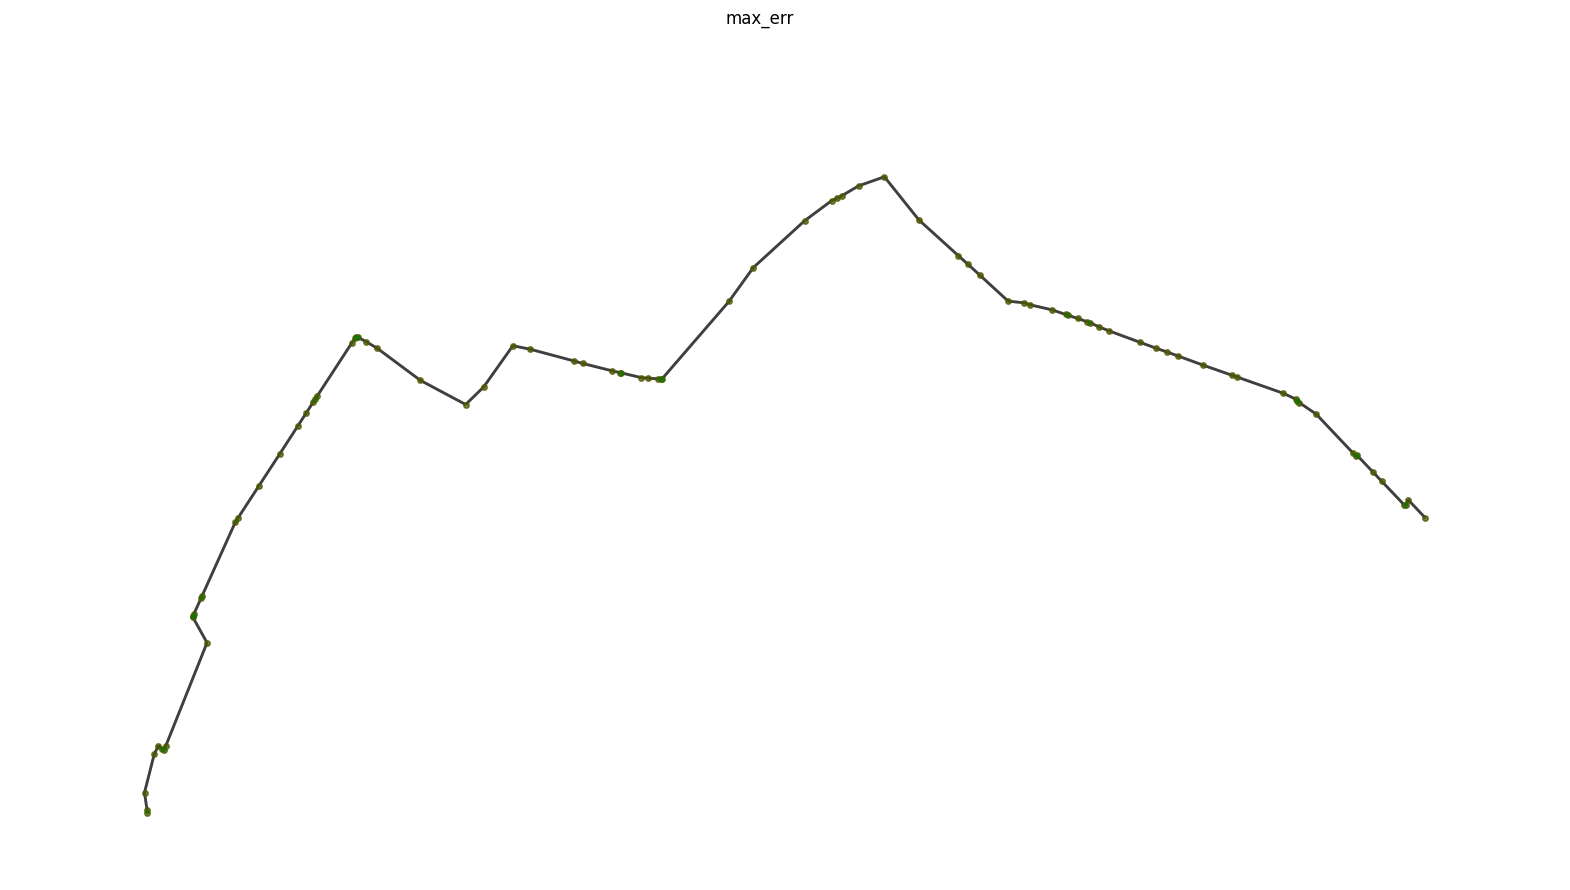

In [90]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
f.suptitle('max_err')


# nx.draw(g, pos=pos, ax=ax, node_size=10, alpha=0.5)
nx.draw(g.subgraph(path), pos=pos, ax=ax, node_size=15, node_color='red', width=2, alpha=0.5)
nx.draw(g.subgraph(h_path), pos=pos, ax=ax, node_size=15, node_color='green', width=2, alpha=0.5)
# nx.draw_networkx_labels(g,pos_l,labels=labels,font_size=6)